In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.polynomial.chebyshev import Chebyshev

import intsam as cheb2utils 

In [2]:
def meshgrid2points(X, Y):
    x1 = X.reshape(-1)
    y1 = Y.reshape(-1)
    xy = np.vstack([x1, y1])
    return xy.transpose()
def get_xy_decompose(f, point, domain, deg):
    a, b, c, d = domain
    x, y = point

    # v(x)
    vx_list = cheb2utils.cheby_root_grid(a, c, deg+1)
    vy_list = np.full_like(vx_list, y)
    vz_list = f(vx_list, vy_list)

    v_i = Chebyshev.fit(vx_list, vz_list, deg=deg, domain=(a, c))
    
    # u(y)
    uy_list = cheb2utils.cheby_root_grid(b, d, deg+1)
    ux_list = np.full_like(uy_list, x)
    uz_list = f(ux_list, uy_list)

    u_i = Chebyshev.fit(uy_list, uz_list, deg=deg, domain=(b, d))

    return v_i, u_i
def stage_1(j):
    j += 1
    return int(2**(j+2)+1), int(2**(j)+1)

In [3]:
def test_function_d(x,y):
    return np.cos(10*(x**2 + y)) +np.sin(10*(x+y**2))
def test_function_c(x,y):
    return 1/(1+1000*(((x**2-1/4)**2) *((y**2-1/4)**2)))

In [82]:
xdim = (-1, 1)
ydim = (-1, 1)
domain = [xdim[0], ydim[0], xdim[1], ydim[1]]
tol_err = 3E-15

In [83]:
j = 5

In [84]:
list(range(4, 10))

[4, 5, 6, 7, 8, 9]

In [85]:
n, max_step = stage_1(j)
cheby_deg= (n-1)

In [86]:
arr = cheb2utils.cheby_root_grid(*xdim, n)
arr.sort()
print(arr)

[-9.99981321e-01 -9.99831898e-01 -9.99533072e-01 -9.99084890e-01
 -9.98487418e-01 -9.97740745e-01 -9.96844983e-01 -9.95800266e-01
 -9.94606750e-01 -9.93264612e-01 -9.91774055e-01 -9.90135301e-01
 -9.88348593e-01 -9.86414200e-01 -9.84332411e-01 -9.82103536e-01
 -9.79727908e-01 -9.77205883e-01 -9.74537838e-01 -9.71724170e-01
 -9.68765301e-01 -9.65661673e-01 -9.62413749e-01 -9.59022015e-01
 -9.55486977e-01 -9.51809164e-01 -9.47989125e-01 -9.44027432e-01
 -9.39924676e-01 -9.35681469e-01 -9.31298448e-01 -9.26776265e-01
 -9.22115597e-01 -9.17317141e-01 -9.12381613e-01 -9.07309750e-01
 -9.02102312e-01 -8.96760075e-01 -8.91283839e-01 -8.85674421e-01
 -8.79932659e-01 -8.74059413e-01 -8.68055558e-01 -8.61921993e-01
 -8.55659634e-01 -8.49269416e-01 -8.42752295e-01 -8.36109244e-01
 -8.29341256e-01 -8.22449342e-01 -8.15434533e-01 -8.08297876e-01
 -8.01040437e-01 -7.93663302e-01 -7.86167573e-01 -7.78554369e-01
 -7.70824828e-01 -7.62980105e-01 -7.55021373e-01 -7.46949821e-01
 -7.38766654e-01 -7.30473

In [87]:
p_x, p_y = np.meshgrid(arr, arr)
points = meshgrid2points(p_x, p_y)

In [88]:
e_k_approx = cheb2utils.RankApprox2dim(lambda x: x, lambda y: y, 0)
f_k = cheb2utils.RankApprox2dim(lambda x: x, lambda y: y, 0)
def e_k(x, y):
    return test_function_c(x, y) + e_k_approx(x, y)
def e_k_np(point):
    return test_function_c(*point) + e_k_approx(*point)

In [89]:
#e_k_val = np.array(list(map(e_k, *(points.transpose())))) # calculate function value

In [90]:
print(p_x.shape)
print(e_k(p_x, p_y).shape)

(257, 257)
(257, 257)


In [91]:
import warnings
warnings.filterwarnings('ignore')

In [92]:
# iteration
_, c_l = p_x.shape 
for k in range(0, max_step):
    #e_k_val = np.array(list(map(e_k, *(points.transpose()))))
    #e_k_val = np.apply_along_axis(e_k_np, axis=0, arr=points.T)
    e_k_val = e_k(p_x, p_y)
    if np.abs(e_k_val).max() < tol_err:
        print("Machine Precise Reached")
        break
    print(f"Rank:{f_k.rank}\tErr:", np.abs(e_k_val).max())
    max_index = np.argmax(e_k_val)
    r = int(max_index/c_l)
    c = max_index%c_l
    x_k, y_k = p_x[r, c], p_y[r, c]

    u_k, v_k = get_xy_decompose(e_k, (x_k, y_k ), domain, cheby_deg)
    d_k  = 1/ e_k(x_k, y_k)

    e_k_approx.rank_up(u_k, v_k, -d_k)
    f_k.rank_up(       u_k, v_k, d_k)
    print(f"f_k rank:{f_k.rank}")

Rank:1	Err: 0.9999999902630735
f_k rank:2
Rank:2	Err: 0.9933479605852914
f_k rank:3
Rank:3	Err: 2.0500040845458547
f_k rank:4
Rank:4	Err: 0.6741295661089584
f_k rank:5
Rank:5	Err: 0.4439971344703327
f_k rank:6
Rank:6	Err: 0.08325523785777766
f_k rank:7
Rank:7	Err: 0.08098334022431924
f_k rank:8
Rank:8	Err: 0.06253420792482589
f_k rank:9
Rank:9	Err: 0.007647738455926256
f_k rank:10
Rank:10	Err: 0.001010713244424255
f_k rank:11
Rank:11	Err: 0.0009701694508950087
f_k rank:12
Rank:12	Err: 0.0003146768544487477
f_k rank:13
Rank:13	Err: 5.7951181872961666e-05
f_k rank:14
Rank:14	Err: 1.8949499264842018e-05
f_k rank:15
Rank:15	Err: 5.493556984925707e-06
f_k rank:16
Rank:16	Err: 1.955815964294061e-06
f_k rank:17
Rank:17	Err: 5.542837117067378e-07
f_k rank:18
Rank:18	Err: 3.4216445415902186e-07
f_k rank:19
Rank:19	Err: 1.3309436408537323e-07
f_k rank:20
Rank:20	Err: 5.52050638171625e-08
f_k rank:21
Rank:21	Err: 6.575529676311476e-09
f_k rank:22
Rank:22	Err: 2.310179936237944e-09
f_k rank:23
Ran

In [60]:
print(f"test_function: {test_function_c(x_k, y_k)}")
print(f"Approximation : {f_k(x_k, y_k)}")

test_function: 0.025266867827195744
Approximation : 0.025266867827195633


In [61]:
# Approximation info
print(f"Rank: {f_k.rank}")

Rank: 34


In [62]:
X, Y = np.meshgrid(np.linspace(*xdim , 200), np.linspace(*ydim , 200))

In [63]:
Z = test_function_c(X,Y)

In [64]:
Z2 = f_k(X,Y)

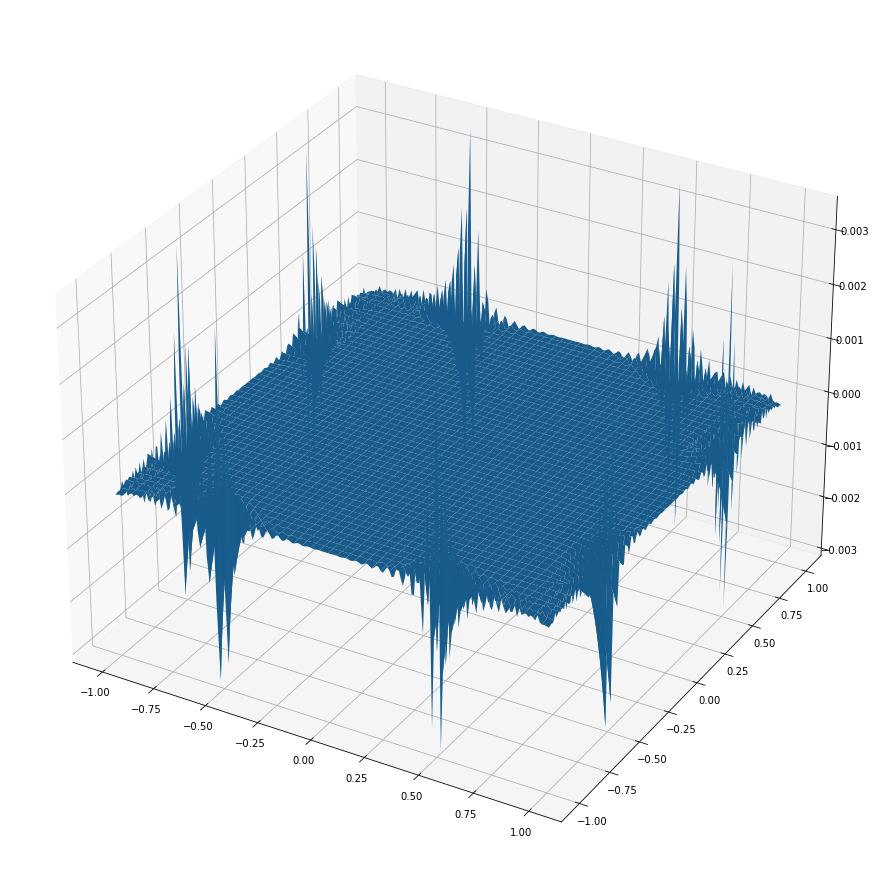

In [93]:
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y ,Z-Z2)
plt.show()

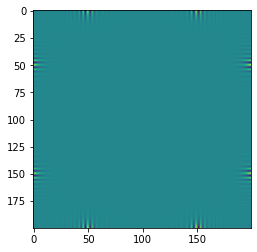

In [94]:
plt.imshow(Z-Z2)

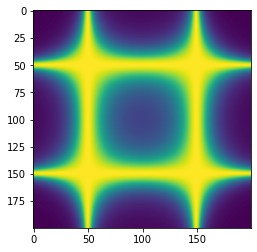

In [67]:
plt.imshow(Z2)

In [99]:
Z2 = f_k(X,Y)

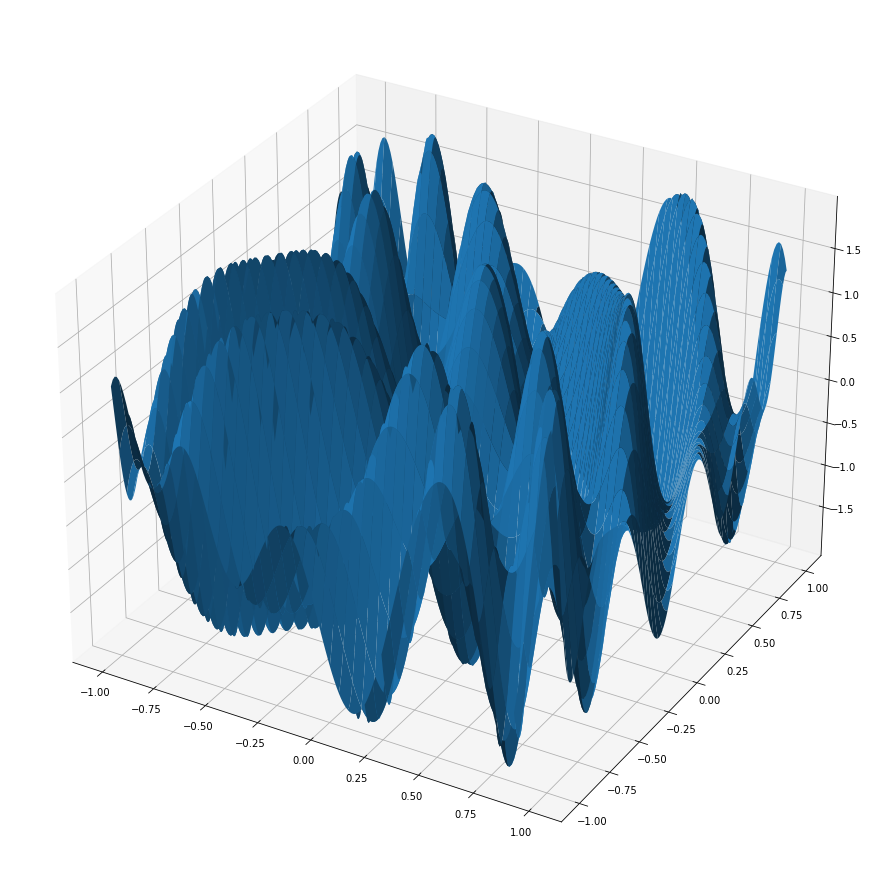

In [32]:
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y ,Z)
plt.show()

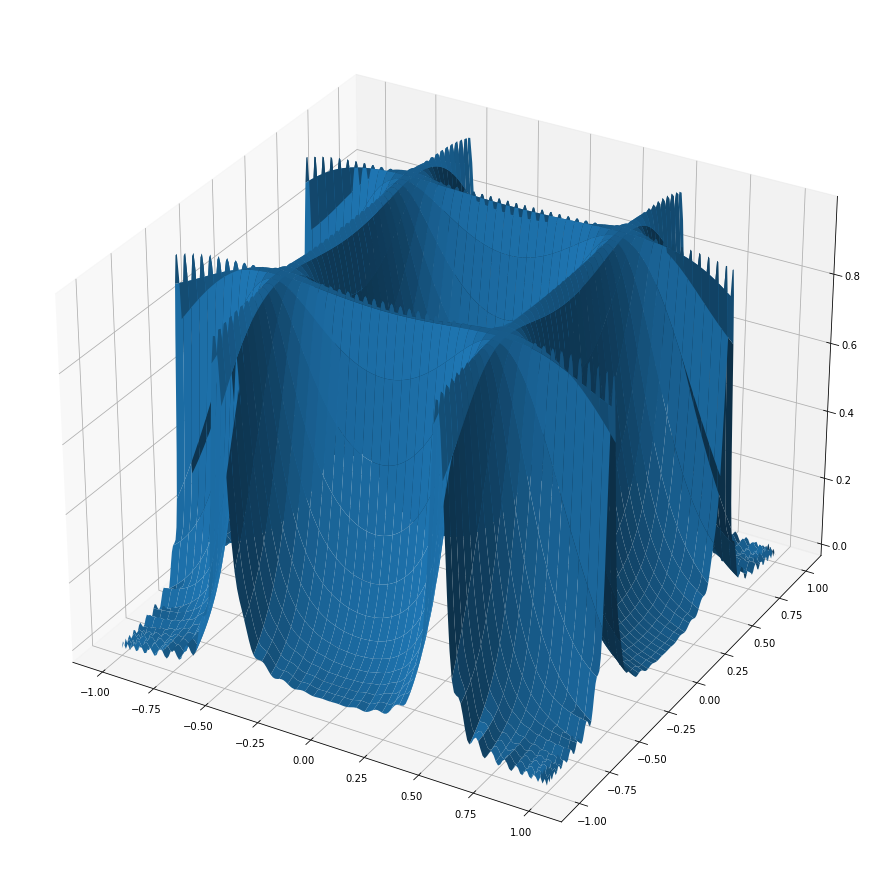

In [20]:
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y ,Z2)
plt.show()

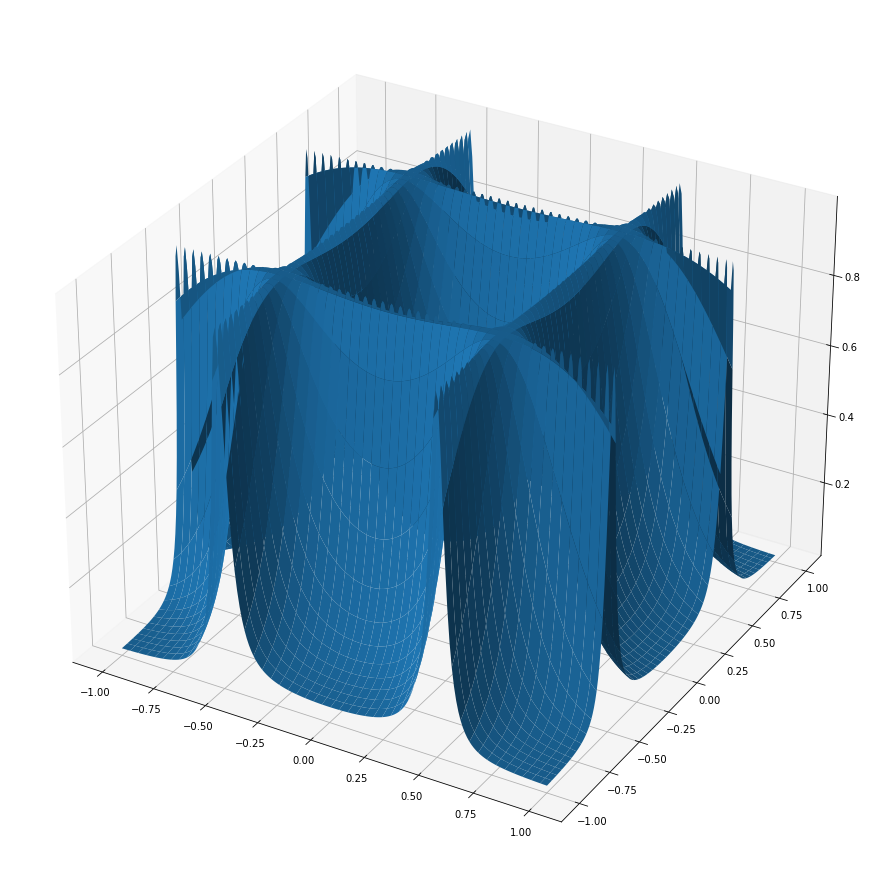

In [21]:
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y ,Z)
plt.show()

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.polynomial.chebyshev import Chebyshev

import intsam as cheb2utils 

In [44]:
def t_d(x,y):
    #return 1/(1+100*(1/2 - x**2 -y**2)**2)
    return 1/(1+100*(x**2-y**2)**2)
    #return np.tanh(10*x)*np.tanh(10*y)/(np.tanh(10)**2) + np.cos(5*x)

In [48]:
f_approx, err = cheb2utils.RankApprox2dim.from_function_approx(t_d, domain=[-1, -1, 1, 1], initial_step=5, max_step=6)
print(f"Err:{err}")
print(f"Rank:{f_approx.rank}")

Err:2.0060363892238087e-07
Rank:66


In [49]:
X, Y = np.meshgrid(np.linspace(-1, 1 , 200), np.linspace(-1, 1 , 200))
Z_ori = t_d(X, Y)
Z_approx = f_approx(X, Y)

7.079151109756765e-08


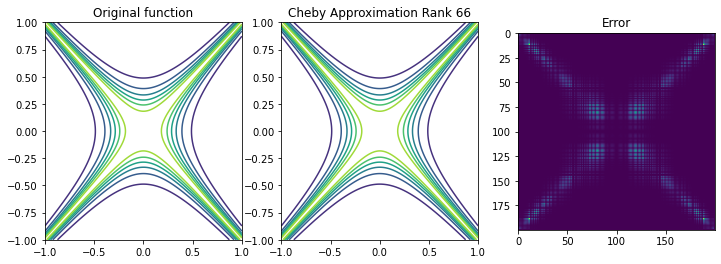

In [64]:
fig = plt.figure(figsize=(12, 12 ))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.contour(X,Y, Z_ori)
ax1.set_title("Original function")
ax2.contour(X,Y, Z_approx)
ax2.set_title(f"Cheby Approximation Rank {f_approx.rank}")
ax3.imshow(np.sqrt((Z_ori - Z_approx)**2))
ax3.set_title("Error")
print(np.sqrt((Z_ori - Z_approx)**2).max())
fig.set_figheight(4)
plt.show()